In [27]:
import sympy as sp

A = sp.Matrix([
    [1, 7, 3],
    [1/7, 1, 1/3],
    [1/3, 3, 1]
])

lambda_sym = sp.symbols('lambda')

# matrix (A - lambda * I)
A_lambda_I = A - lambda_sym * sp.eye(3)
determinant = A_lambda_I.det()

# solving the characteristic equation det(A - lambda * I) = 0 for eigenvalues
eigenvalues = sp.solve(determinant, lambda_sym)
eigenvalues


[3.00702176512993,
 -0.00351088256496619 - 0.1452662186434*I,
 -0.00351088256496619 + 0.1452662186434*I]

In [28]:
import pandas as pd

df = pd.read_csv('/Users/katerynaivaniuk/Downloads/Bridge Reconstructions - Sheet1 (2).csv')
df


,Bridge ID,Bridge Name,Region,Bridge Function,Reconstruction Costs,Volume (Num of vehicles per day on average),Total Area of the Damage,Damage Level,Length of the bridge damaged (m),Width of the bridge damaged (m)
0,ID004,Bakhmut Rail Bridge,Donetsk,Railway,"556,311.00","3,200",185.437,L4,41.3,4.49
1,ID013,Siverskyi Donetsk River Bridge,Donetsk,Railway,"1,887,840.00","6,800",629.280,L4,114.0,5.52
2,ID021,Bohorodychne Bridge,Donetsk,Highway,"4,176,000.00","8,700",1392.000,L4,120.0,11.60
3,ID015,Staryi Saltiv Dam Bridge,Kharkiv,Highway,"710,964.00","8,000",236.988,L4,34.8,6.81
4,ID016,Rus'ka Lozova Bridge,Kharkiv,Railway,"1,972,860.00",120,657.620,L4,50.2,13.10
5,ID020,Horokhovatka Bridge,Kharkiv,Highway,"1,326,960.00","3,500",442.320,L4,58.2,7.60
6,ID001,Antonivsky Bridge,Kherson,Highway,"6,825,000.00","7,600",2275.000,L4,91.0,25.00
7,ID005,Chongar Bridge,Kherson,Highway,"963,360.00","8,100",321.120,L3,22.3,14.40
8,ID009,Darivka Bridge,Kherson,Highway,"6,129,900.00",9400,2043.300,L4,139.0,14.70
9,ID011,Henichesk Bridge,Kherson,Highway and Railway,"719,550.00","5,300",239.850,L3,19.5,12.30


In [29]:
print(df.columns)

Index(['Bridge ID ', 'Bridge Name ', 'Region', 'Bridge Function',
       'Reconstruction Costs', 'Volume (Num of vehicles per day on average) ',
       'Total Area of the Damage ', 'Damage Level ',
       'Length of the bridge damaged (m)', 'Width of the bridge damaged (m)'],
      dtype='object')


In [30]:
df['Bridge Function'] = df['Bridge Function'].str.strip()
df['Bridge Function'] = df['Bridge Function'].replace({"Highway and Railway": "Highway"})

# Mapping bridge function (highway vs. railway) to numeric values
df['Bridge Function'] = df['Bridge Function'].map({'Highway': 1, 'Railway': 0})

print(df['Bridge Function'])


0     0.0
1     0.0
2     1.0
3     1.0
4     0.0
5     1.0
6     1.0
7     1.0
8     1.0
9     1.0
10    1.0
11    1.0
12    1.0
13    1.0
14    1.0
15    1.0
16    0.0
17    1.0
18    1.0
19    1.0
20    1.0
21    1.0
22    NaN
23    NaN
24    NaN
Name: Bridge Function, dtype: float64


In [31]:
import numpy as np
from IPython.display import display, Markdown


def ahp_pairwise_comparison_matrix():
    return np.array([
        [1, 7, 3],   
        [1/7, 1, 1/3],  
        [1/3, 3, 1]   
    ])

def calculate_ahp_weights(pairwise_matrix):
    # Normalizing and calculating weights (priority vector) for each criterion
    column_sums = pairwise_matrix.sum(axis=0)
    normalized_matrix = pairwise_matrix / column_sums
    priority_vector = normalized_matrix.mean(axis=1)

    # Consistency check
    weighted_sum = np.dot(pairwise_matrix, priority_vector)
    lambda_max = (weighted_sum / priority_vector).mean()
    CI = (lambda_max - len(pairwise_matrix)) / (len(pairwise_matrix) - 1)
    RI = 0.58  # for 3x3 matrix
    CR = CI / RI

    if CR < 0.1:
        return priority_vector
    else:
        raise ValueError("The pairwise matrix is inconsistent (CR > 0.1). Please adjust the values.")

# Applying AHP Algorithm Within Each Region
results = []

for region, group in df.groupby("Region"):
    if len(group) > 1:
        volume = pd.to_numeric(group['Volume (Num of vehicles per day on average) '].replace({',': ''}, regex=True))
        cost = pd.to_numeric(group['Reconstruction Costs'].replace({',': '', '€': ''}, regex=True))
        function = group['Bridge Function']
        
        # Normalizing Volume and Cost within the region
        total_volume = volume.sum()
        total_cost = cost.sum()

        normalized_volume = volume / total_volume
        normalized_cost = cost / total_cost

        # Getting weights for Volume, Cost, and Function
        pairwise_matrix = ahp_pairwise_comparison_matrix()
        weights = calculate_ahp_weights(pairwise_matrix)

        # Calculating AHP score for each bridge in the region
        scores = (normalized_volume * weights[0]) + (normalized_cost * weights[1]) + (function * weights[2])

        region_results = pd.DataFrame({
            'Region': region,
            'Bridge ID': group['Bridge ID '],
            'AHP Score': scores
        }).sort_values(by='AHP Score', ascending=False)
        
        results.append(region_results)

for region_results in results:
    region = region_results['Region'].iloc[0]  # Get the region name
    display(Markdown(f"### **Prioritization for Region: {region}**"))

    for _, row in region_results.iterrows():
        print(f"Bridge {row['Bridge ID']} with AHP Score: {row['AHP Score']:.4f}")


### **Prioritization for Region: Donetsk **

Bridge ID021 with AHP Score: 0.6098
Bridge ID013 with AHP Score: 0.2683
Bridge ID004 with AHP Score: 0.1218


### **Prioritization for Region: Kharkiv **

Bridge ID015 with AHP Score: 0.7191
Bridge ID020 with AHP Score: 0.4737
Bridge ID016 with AHP Score: 0.0503


### **Prioritization for Region: Kherson**

Bridge ID009 with AHP Score: 0.4868
Bridge ID001 with AHP Score: 0.4514
Bridge ID005 with AHP Score: 0.4271
Bridge ID011 with AHP Score: 0.3640


### **Prioritization for Region: Luhansk**

Bridge ID017 with AHP Score: 0.5708
Bridge ID010 with AHP Score: 0.4770
Bridge ID019 with AHP Score: 0.3299
Bridge ID007 with AHP Score: 0.3048
Bridge ID018 with AHP Score: 0.0468


### **Prioritization for Region: Zaporizhzhia **

Bridge ID014 with AHP Score: 0.7041
Bridge ID002 with AHP Score: 0.5390


Trial 1: [1. 6. 8.]
Trial 2: [1. 4. 7.]
Trial 3: [1. 2. 6.]
Trial 4: [1. 9. 9.]
Trial 5: [1. 6. 9.]


### **AHP Score Summary**

       Region Bridge ID  Mean AHP Score  Median AHP Score  Std Dev  Min AHP Score  Max AHP Score
     Donetsk      ID004        0.125476          0.127986 0.016498       0.085052       0.147649
     Donetsk      ID013        0.286456          0.299297 0.032799       0.187897       0.323445
     Donetsk      ID021        0.588068          0.577837 0.048581       0.528906       0.726631
     Kharkiv      ID015        0.663302          0.666282 0.068841       0.462715       0.809130
     Kharkiv      ID016        0.087206          0.069861 0.046320       0.030781       0.237892
     Kharkiv      ID020        0.437288          0.407758 0.080212       0.352025       0.633773
      Kherson     ID001        0.418934          0.401381 0.076780       0.337842       0.616645
      Kherson     ID005        0.355861          0.332637 0.091534       0.210018       0.603360
      Kherson     ID009        0.448321          0.423522 0.072082       0.381970       0.642193
      Kherson     ID011       

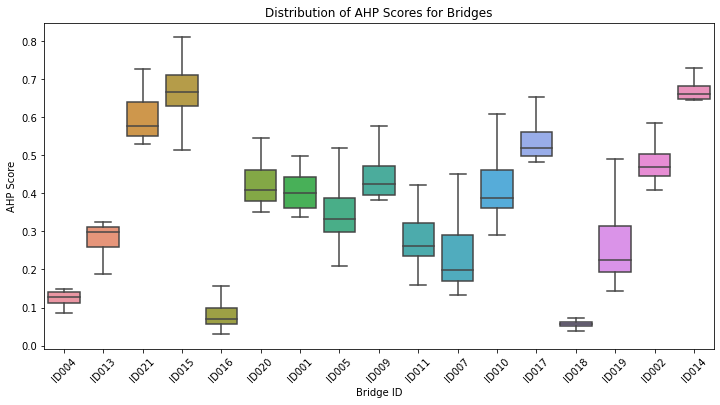

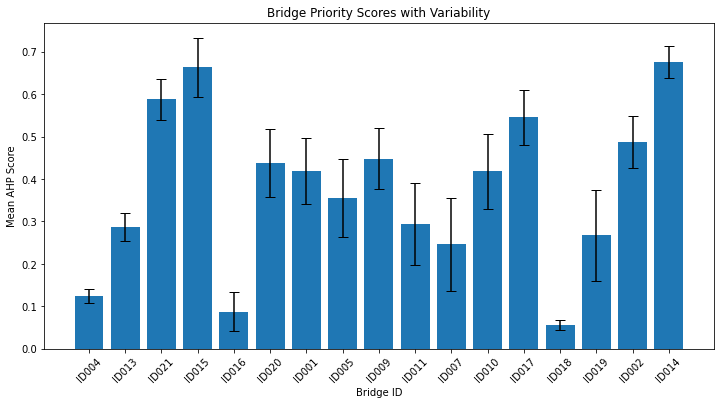

In [36]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown



def generate_consistent_ahp_matrix(n):
    """
    Generates a perfectly consistent AHP pairwise comparison matrix using only standard AHP values:
    {1, 3, 5, 7, 9} and their reciprocals, ensuring consistency (CR = 0).
    """
    A = np.ones((n, n))  # Identity matrix (A[i, i] = 1)

    # Generate the first row with valid AHP values
    valid_values = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9])
    for j in range(1, n):
        A[0, j] = np.random.choice(valid_values)
        A[j, 0] = 1 / A[0, j]  # Ensure reciprocity

    # Fill the rest of the matrix using transitivity: A[i, k] = A[i, j] * A[j, k]
    for i in range(1, n):
        for j in range(i + 1, n):
            A[i, j] = A[i, 0] * A[0, j]  # Transitive relation
            A[j, i] = 1 / A[i, j]  # Ensure reciprocal property


    return A

def calculate_ahp_weights(pairwise_matrix):
    """
    Calculates the AHP weights (priority vector) using the normalized (arithmetic mean) method.
    """
    column_sums = pairwise_matrix.sum(axis=0)
    normalized_matrix = pairwise_matrix / column_sums
    priority_vector = normalized_matrix.mean(axis=1)
    return priority_vector

def compute_scores(group, weights):
    """
    Computes normalized AHP scores based on:
      - Volume (vehicles per day),
      - Reconstruction Costs, and
      - Bridge Function.
    """
    volume = pd.to_numeric(group['Volume (Num of vehicles per day on average) '].replace({',':''}, regex=True))
    cost = pd.to_numeric(group['Reconstruction Costs'].replace({',':'', '€':''}, regex=True))
    function = group['Bridge Function']
    
    total_volume = volume.sum()
    total_cost = cost.sum()
    
    normalized_volume = volume / total_volume
    normalized_cost = cost / total_cost
    
    scores = normalized_volume * weights[0] + normalized_cost * weights[1] + function * weights[2]
    return scores

# --- Data Preparation ---

df = pd.read_csv('/Users/katerynaivaniuk/Downloads/Bridge Reconstructions - Sheet1 (2).csv')
df['Bridge Function'] = df['Bridge Function'].str.strip()
df['Bridge Function'] = df['Bridge Function'].replace({"Highway and Railway": "Highway"})
df['Bridge Function'] = df['Bridge Function'].map({'Highway': 1, 'Railway': 0})


num_trials = 100  
score_results = {}


for region, group in df.groupby("Region"):
    if len(group) > 1:
        
        for bridge_id in group['Bridge ID '].values:
            score_results[bridge_id] = []

        for trial in range(num_trials):
            random.seed()  # Resets the random seed each iteration
            A = generate_consistent_ahp_matrix(3)  # 3 criteria (Volume, Cost, Function)
            weights = calculate_ahp_weights(A)
            scores = compute_scores(group, weights)


            for idx, bridge_id in enumerate(group['Bridge ID '].values):
                score_results[bridge_id].append(scores.iloc[idx])

summary_list = []
for bridge_id, scores in score_results.items():
    region_name = df.loc[df['Bridge ID '] == bridge_id, 'Region'].values[0]

    summary_list.append({
        'Region': region_name,  
        'Bridge ID': bridge_id,
        'Mean AHP Score': round(np.mean(scores), 6),
        'Median AHP Score': round(np.median(scores), 6),
        'Std Dev': round(np.std(scores), 6),
        'Min AHP Score': round(np.min(scores), 6),
        'Max AHP Score': round(np.max(scores), 6)
    })

summary_df = pd.DataFrame(summary_list)

display(Markdown("### **AHP Score Summary**"))  
print(summary_df.to_string(index=False))


plt.figure(figsize=(12, 6))
sns.boxplot(data=pd.DataFrame(score_results), showfliers=False)  # Hides outliers
plt.xlabel("Bridge ID")
plt.ylabel("AHP Score")
plt.title("Distribution of AHP Scores for Bridges")
plt.xticks(rotation=45)
plt.show()



In [ ]:
# Bar chart with error bars (Mean ± Std Dev)
plt.figure(figsize=(12, 6))
plt.bar(summary_df['Bridge ID'], summary_df['Mean AHP Score'], yerr=summary_df['Std Dev'], capsize=5)
plt.xlabel("Bridge ID")
plt.ylabel("Mean AHP Score")
plt.title("Bridge Priority Scores with Variability")
plt.xticks(rotation=45)
plt.show()